In [ ]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
test_sample_image='/Users/hariprasaathvv/Downloads/DL Project/colab_data/Train/Effusion/00000231_002.png'

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# Load the image file
image_path = test_sample_image
image = Image.open(image_path)

def add_gaussian_noise(image, mean=0, std=0.1):
    image = transforms.ToTensor()(image)  # Convert the image to a tensor
    noise = torch.randn_like(image) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure the image values are in the valid range [0, 1]
    return transforms.ToPILImage()(noisy_image)  # Convert the tensor back to an image

# Create a custom transformation using transforms.Lambda
add_gaussian_noise_transform = transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0, std=0.1))

# Define data augmentation transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5),
    transforms.RandomRotation(25),  # Randomly rotate the image up to 20 degrees
    transforms.RandomVerticalFlip(),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2))], p=0.5),  # Apply random affine transformations
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2, p=0.5)], p=0.5),  # Apply random perspective transformation
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([add_gaussian_noise_transform],p=0.5),
    transforms.ToTensor(),

])


# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# # Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)


Tensor shape: torch.Size([1, 1, 224, 224])
Tensor data type: torch.float32


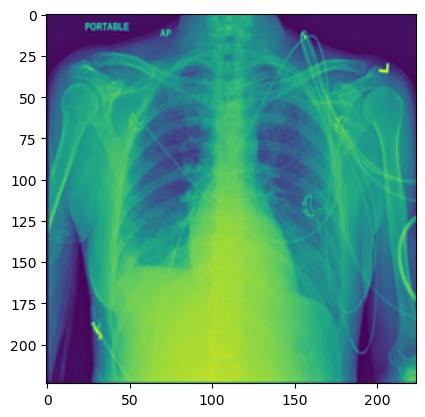

In [ ]:
plt.imshow(image)

In [ ]:
import torch
import torch.nn as nn
print(torch.__version__)

# A cardianlity block in ResNeXt50 has 32 similar elements.
# Each element contains Conv2D(1x1) -> Conv2D(3x3) -> Conv2D(1x1)
class CardinalityBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1, C = 32):
        super(CardinalityBlock, self).__init__()
        self.expansion = 2
        self.small_out_channels = out_channels // C # actual number of out channels for each element.
        self.conv1 = nn.Conv2d(in_channels, self.small_out_channels, kernel_size = 1, stride = 1, padding = 0)
        self.bn1 = nn.BatchNorm2d(self.small_out_channels)
        self.conv2 = nn.Conv2d(self.small_out_channels, self.small_out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn2 = nn.BatchNorm2d(self.small_out_channels)
        self.conv3 = nn.Conv2d(self.small_out_channels, self.small_out_channels * self.expansion, kernel_size = 1, stride = 1, padding = 0)
        self.bn3 = nn.BatchNorm2d(self.small_out_channels * self.expansion)
        self.relu = nn.ReLU()
        # pack 3 conv blocks into a whole vertical branch
        self.branch = nn.Sequential(self.conv1, self.bn1, self.conv2, self.bn2, self.conv3, self.bn3)
        self.identity_downsample = identity_downsample
        self.C = C


    def forward(self, x):
        # get information from previous cardinality block
        identity = x
        branch_list = []

        # concat all 32 branches
        for i in range(self.C):
            branch_list.append(self.branch(x))

        x = torch.cat(branch_list, 1)

        # add identity information when it is not None (after a whole branch)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

# ResNeXt architecture
class ResNeXt(nn.Module):
    def __init__(self, cardinalityBlock, num_repeat, image_channels, num_classes):
        super(ResNeXt, self).__init__()
        # Before ResBlock
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size = 7, stride = 2, padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        # ResBlock. For ResNeXt50, num_repeat = [3, 4, 6, 3]
        self.conv2 = self.create_resBlock(cardinalityBlock, num_repeat[0], out_channels=128, stride=1)
        self.conv3 = self.create_resBlock(cardinalityBlock, num_repeat[1], out_channels=256, stride=2)
        self.conv4 = self.create_resBlock(cardinalityBlock, num_repeat[2], out_channels=512, stride=2)
        self.conv5 = self.create_resBlock(cardinalityBlock, num_repeat[3], out_channels=1024, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024 * 2, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x


    def create_resBlock(self, cardinalityBlock, num_blocks, out_channels, stride):
        identity_downsample = None
        conv_layers = []

        # Only apply identity when changing to the new conv layer
        if self.in_channels != out_channels * 2:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * 2, kernel_size = 1, stride = stride),
                                                nn.BatchNorm2d(out_channels * 2))
        conv_layers.append(cardinalityBlock(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 2 # expansion rate of 2

        for i in range(num_blocks - 1):
            conv_layers.append(cardinalityBlock(self.in_channels, out_channels))
        return nn.Sequential(*conv_layers)

def ResNeXt50(image_channels = 3, num_classes = 1000):
    return ResNeXt(CardinalityBlock, [3, 4, 6, 3], image_channels, num_classes)

# if __name__ == '__main__':
#     x = torch.randn(3, 3, 224, 224)

#     print(model(x).shape) # torch.Size([3, 1000])

model = ResNeXt50()

2.1.0


In [ ]:
train_dir = os.path.join("/Users/hariprasaathvv/Downloads/DL Project/colab_data/Train")
test_dir = os.path.join("/Users/hariprasaathvv/Downloads/DL Project/colab_data/Test")

In [ ]:
os.cpu_count()

12

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#NUM_WORKERS = os.cpu_count()
NUM_WORKERS=0

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Set the batch size
BATCH_SIZE = 28

import torch
from torchvision.transforms import v2
import torchvision.transforms as transforms


# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x14ec07f90>,
 ['Cardiomegaly', 'Consolidation', 'Effusion'])

In [ ]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 5166472


In [ ]:
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

True
True


In [ ]:
import torch
from torchsummary import summary

import torch

# Move the model to GPU
model = model.to("mps")

In [ ]:
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print(f"Using device: {device}")


Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [ ]:

"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):

    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):

    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):


    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:

    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path


In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    print("step")
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in tqdm(enumerate(dataloader)):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        checkpoint_filename = '/Users/hariprasaathvv/Downloads/DL Project/weights/'+str(epoch)+'.pt'
        torch.save(model.state_dict(), checkpoint_filename)
    # Return the filled results at the end of the epochs
    return results

In [ ]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.0001,
                             betas=(0.9, 0.999),
                             weight_decay=0.01)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       device=device)
checkpoint_filename = '/Users/hariprasaathvv/Downloads/DL Project/weights/'+str("final")+'.pt'
torch.save(model.state_dict(), checkpoint_filename)


Started


  0%|          | 0/100 [00:00<?, ?it/s]

step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.5565 | train_acc: 0.3818 | test_loss: 1.0656 | test_acc: 0.4508
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 1.1039 | train_acc: 0.4098 | test_loss: 1.1546 | test_acc: 0.3452
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 1.0779 | train_acc: 0.4196 | test_loss: 1.0861 | test_acc: 0.4448
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 1.0794 | train_acc: 0.4262 | test_loss: 1.0814 | test_acc: 0.4264
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 1.0786 | train_acc: 0.4225 | test_loss: 1.1660 | test_acc: 0.3810
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 1.0647 | train_acc: 0.4457 | test_loss: 1.1027 | test_acc: 0.4378
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 1.0723 | train_acc: 0.4257 | test_loss: 1.0804 | test_acc: 0.3642
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 1.0758 | train_acc: 0.4349 | test_loss: 1.0257 | test_acc: 0.4800
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 1.0618 | train_acc: 0.4413 | test_loss: 1.0752 | test_acc: 0.4475
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 1.0536 | train_acc: 0.4567 | test_loss: 1.0488 | test_acc: 0.4172
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 11 | train_loss: 1.0582 | train_acc: 0.4606 | test_loss: 1.0501 | test_acc: 0.4459
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 12 | train_loss: 1.0548 | train_acc: 0.4466 | test_loss: 1.1181 | test_acc: 0.4021
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 13 | train_loss: 1.0550 | train_acc: 0.4511 | test_loss: 1.0163 | test_acc: 0.4773
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 14 | train_loss: 1.0526 | train_acc: 0.4597 | test_loss: 1.0720 | test_acc: 0.4713
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 15 | train_loss: 1.0543 | train_acc: 0.4645 | test_loss: 1.1013 | test_acc: 0.4562
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 16 | train_loss: 1.0483 | train_acc: 0.4653 | test_loss: 1.1156 | test_acc: 0.4600
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 17 | train_loss: 1.0462 | train_acc: 0.4574 | test_loss: 1.1431 | test_acc: 0.4226
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 18 | train_loss: 1.0580 | train_acc: 0.4491 | test_loss: 1.0047 | test_acc: 0.5254
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 19 | train_loss: 1.0472 | train_acc: 0.4648 | test_loss: 1.0743 | test_acc: 0.4475
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 20 | train_loss: 1.0388 | train_acc: 0.4699 | test_loss: 1.2178 | test_acc: 0.3274
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 21 | train_loss: 1.0434 | train_acc: 0.4673 | test_loss: 1.0838 | test_acc: 0.4767
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 22 | train_loss: 1.0433 | train_acc: 0.4701 | test_loss: 0.9936 | test_acc: 0.5043
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 23 | train_loss: 1.0390 | train_acc: 0.4761 | test_loss: 1.0180 | test_acc: 0.5108
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 24 | train_loss: 1.0371 | train_acc: 0.4674 | test_loss: 1.0412 | test_acc: 0.4470
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 25 | train_loss: 1.0409 | train_acc: 0.4651 | test_loss: 1.0069 | test_acc: 0.5130
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 26 | train_loss: 1.0301 | train_acc: 0.4764 | test_loss: 0.9747 | test_acc: 0.5547
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 27 | train_loss: 1.0284 | train_acc: 0.4891 | test_loss: 1.0093 | test_acc: 0.4957
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 28 | train_loss: 1.0331 | train_acc: 0.4752 | test_loss: 0.9938 | test_acc: 0.5054
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 29 | train_loss: 1.0307 | train_acc: 0.4733 | test_loss: 1.0344 | test_acc: 0.5487
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 30 | train_loss: 1.0289 | train_acc: 0.4806 | test_loss: 1.0242 | test_acc: 0.5249
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 31 | train_loss: 1.0298 | train_acc: 0.4761 | test_loss: 1.0863 | test_acc: 0.4356
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 32 | train_loss: 1.0307 | train_acc: 0.4817 | test_loss: 0.9951 | test_acc: 0.4957
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 33 | train_loss: 1.0330 | train_acc: 0.4877 | test_loss: 1.0283 | test_acc: 0.4719
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 34 | train_loss: 1.0249 | train_acc: 0.4736 | test_loss: 1.0221 | test_acc: 0.4437
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 35 | train_loss: 1.0258 | train_acc: 0.4899 | test_loss: 1.0993 | test_acc: 0.4556
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 36 | train_loss: 1.0277 | train_acc: 0.4855 | test_loss: 1.0620 | test_acc: 0.4589
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 37 | train_loss: 1.0249 | train_acc: 0.4952 | test_loss: 1.1370 | test_acc: 0.3690
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 38 | train_loss: 1.0106 | train_acc: 0.4968 | test_loss: 0.9424 | test_acc: 0.5579
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 39 | train_loss: 1.0132 | train_acc: 0.4963 | test_loss: 0.9925 | test_acc: 0.4962
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 40 | train_loss: 1.0017 | train_acc: 0.5004 | test_loss: 0.9850 | test_acc: 0.5103
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 41 | train_loss: 1.0030 | train_acc: 0.5112 | test_loss: 1.0239 | test_acc: 0.4832
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 42 | train_loss: 1.0123 | train_acc: 0.4929 | test_loss: 1.0137 | test_acc: 0.4946
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 43 | train_loss: 1.0115 | train_acc: 0.4923 | test_loss: 1.0939 | test_acc: 0.3988
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 44 | train_loss: 1.0151 | train_acc: 0.4931 | test_loss: 0.9524 | test_acc: 0.5974
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 45 | train_loss: 1.0040 | train_acc: 0.5036 | test_loss: 0.9917 | test_acc: 0.5038
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 46 | train_loss: 1.0046 | train_acc: 0.4972 | test_loss: 0.9638 | test_acc: 0.5276
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 47 | train_loss: 0.9951 | train_acc: 0.5095 | test_loss: 0.9890 | test_acc: 0.5427
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 48 | train_loss: 0.9952 | train_acc: 0.5175 | test_loss: 0.9751 | test_acc: 0.5308
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 49 | train_loss: 0.9906 | train_acc: 0.5139 | test_loss: 0.9588 | test_acc: 0.5552
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 50 | train_loss: 0.9878 | train_acc: 0.5191 | test_loss: 1.0283 | test_acc: 0.4984
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 51 | train_loss: 0.9970 | train_acc: 0.4970 | test_loss: 0.9847 | test_acc: 0.5065
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 52 | train_loss: 0.9829 | train_acc: 0.5137 | test_loss: 0.9428 | test_acc: 0.5763
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 53 | train_loss: 0.9945 | train_acc: 0.5098 | test_loss: 0.9315 | test_acc: 0.5693
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 54 | train_loss: 0.9822 | train_acc: 0.5145 | test_loss: 0.9547 | test_acc: 0.5276
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 55 | train_loss: 0.9842 | train_acc: 0.5100 | test_loss: 0.9341 | test_acc: 0.5644
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 56 | train_loss: 0.9819 | train_acc: 0.5150 | test_loss: 0.9265 | test_acc: 0.5947
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 57 | train_loss: 0.9914 | train_acc: 0.5071 | test_loss: 0.9698 | test_acc: 0.5584
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 58 | train_loss: 0.9839 | train_acc: 0.5162 | test_loss: 0.8793 | test_acc: 0.6001
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 59 | train_loss: 0.9744 | train_acc: 0.5233 | test_loss: 0.9512 | test_acc: 0.5487
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 60 | train_loss: 0.9668 | train_acc: 0.5298 | test_loss: 0.9869 | test_acc: 0.5032
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 61 | train_loss: 0.9599 | train_acc: 0.5442 | test_loss: 0.9839 | test_acc: 0.5335
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 62 | train_loss: 0.9680 | train_acc: 0.5321 | test_loss: 0.9081 | test_acc: 0.5942
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 63 | train_loss: 0.9671 | train_acc: 0.5325 | test_loss: 0.9589 | test_acc: 0.5244
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 64 | train_loss: 0.9609 | train_acc: 0.5439 | test_loss: 0.9473 | test_acc: 0.5341
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 65 | train_loss: 0.9618 | train_acc: 0.5181 | test_loss: 1.0032 | test_acc: 0.4924
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 66 | train_loss: 0.9528 | train_acc: 0.5454 | test_loss: 0.8997 | test_acc: 0.5936
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 67 | train_loss: 0.9608 | train_acc: 0.5274 | test_loss: 0.8843 | test_acc: 0.6061
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 68 | train_loss: 0.9472 | train_acc: 0.5347 | test_loss: 1.0188 | test_acc: 0.5487
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 69 | train_loss: 0.9521 | train_acc: 0.5350 | test_loss: 0.9255 | test_acc: 0.5611
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 70 | train_loss: 0.9511 | train_acc: 0.5357 | test_loss: 0.9286 | test_acc: 0.5519
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 71 | train_loss: 0.9645 | train_acc: 0.5220 | test_loss: 0.9712 | test_acc: 0.5498
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 72 | train_loss: 0.9667 | train_acc: 0.5329 | test_loss: 0.9617 | test_acc: 0.5455
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 73 | train_loss: 0.9404 | train_acc: 0.5519 | test_loss: 0.8792 | test_acc: 0.5823
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 74 | train_loss: 0.9395 | train_acc: 0.5406 | test_loss: 0.9253 | test_acc: 0.6120
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 75 | train_loss: 0.9455 | train_acc: 0.5399 | test_loss: 0.8425 | test_acc: 0.6299
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 76 | train_loss: 0.9322 | train_acc: 0.5434 | test_loss: 0.8608 | test_acc: 0.6115
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 77 | train_loss: 0.9383 | train_acc: 0.5401 | test_loss: 0.9632 | test_acc: 0.5400
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 78 | train_loss: 0.9484 | train_acc: 0.5415 | test_loss: 0.9322 | test_acc: 0.5368
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 79 | train_loss: 0.9356 | train_acc: 0.5474 | test_loss: 0.9889 | test_acc: 0.4978
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 80 | train_loss: 0.9349 | train_acc: 0.5485 | test_loss: 0.9218 | test_acc: 0.5606
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 81 | train_loss: 0.9318 | train_acc: 0.5519 | test_loss: 0.8919 | test_acc: 0.6055
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 82 | train_loss: 0.9266 | train_acc: 0.5515 | test_loss: 0.8623 | test_acc: 0.6266
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 83 | train_loss: 0.9285 | train_acc: 0.5512 | test_loss: 1.0243 | test_acc: 0.5335
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 84 | train_loss: 0.9209 | train_acc: 0.5501 | test_loss: 1.0620 | test_acc: 0.5157
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 85 | train_loss: 0.9248 | train_acc: 0.5534 | test_loss: 0.9251 | test_acc: 0.6326
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 86 | train_loss: 0.9240 | train_acc: 0.5594 | test_loss: 0.9042 | test_acc: 0.5758
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 87 | train_loss: 0.9162 | train_acc: 0.5606 | test_loss: 0.8505 | test_acc: 0.5644
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 88 | train_loss: 0.9144 | train_acc: 0.5559 | test_loss: 0.8879 | test_acc: 0.5693
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 89 | train_loss: 0.9093 | train_acc: 0.5589 | test_loss: 0.9279 | test_acc: 0.5427
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 90 | train_loss: 0.9171 | train_acc: 0.5558 | test_loss: 0.9267 | test_acc: 0.5606
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 91 | train_loss: 0.9143 | train_acc: 0.5589 | test_loss: 0.9166 | test_acc: 0.5547
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 92 | train_loss: 0.9099 | train_acc: 0.5582 | test_loss: 0.9299 | test_acc: 0.5433
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 93 | train_loss: 0.9019 | train_acc: 0.5673 | test_loss: 0.8782 | test_acc: 0.6115
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 94 | train_loss: 0.9057 | train_acc: 0.5643 | test_loss: 0.8998 | test_acc: 0.5703
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 95 | train_loss: 0.9068 | train_acc: 0.5642 | test_loss: 0.9221 | test_acc: 0.5633
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 96 | train_loss: 0.8897 | train_acc: 0.5753 | test_loss: 0.8237 | test_acc: 0.6088
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 97 | train_loss: 0.8991 | train_acc: 0.5699 | test_loss: 0.8419 | test_acc: 0.6623
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 98 | train_loss: 0.8959 | train_acc: 0.5717 | test_loss: 1.0110 | test_acc: 0.5368
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 99 | train_loss: 0.8981 | train_acc: 0.5722 | test_loss: 0.8171 | test_acc: 0.6385
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 100 | train_loss: 0.8915 | train_acc: 0.5793 | test_loss: 0.8943 | test_acc: 0.5785


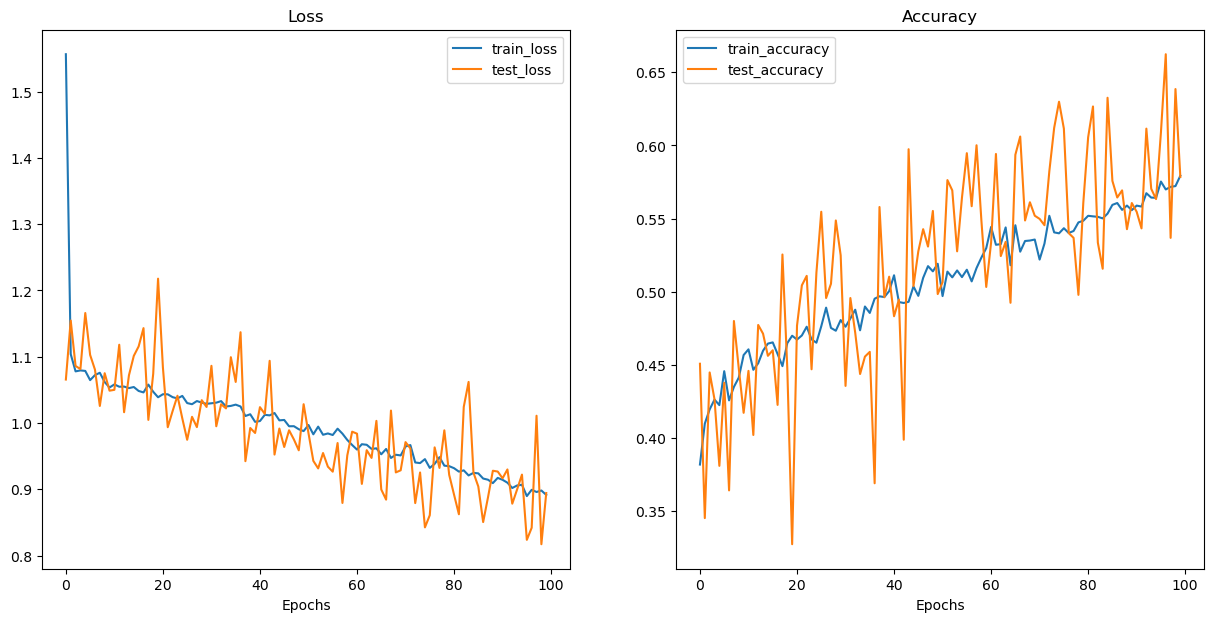

In [ ]:
plot_loss_curves(results)

### Inference

In [ ]:
import os
class_names=["Cardiomegaly","Consolidation","Effusion"]
from torchvision import datasets, transforms

In [ ]:
import torch
import torch.nn as nn
print(torch.__version__)

# A cardianlity block in ResNeXt50 has 32 similar elements.
# Each element contains Conv2D(1x1) -> Conv2D(3x3) -> Conv2D(1x1)
class CardinalityBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1, C = 32):
        super(CardinalityBlock, self).__init__()
        self.expansion = 2
        self.small_out_channels = out_channels // C # actual number of out channels for each element.
        self.conv1 = nn.Conv2d(in_channels, self.small_out_channels, kernel_size = 1, stride = 1, padding = 0)
        self.bn1 = nn.BatchNorm2d(self.small_out_channels)
        self.conv2 = nn.Conv2d(self.small_out_channels, self.small_out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn2 = nn.BatchNorm2d(self.small_out_channels)
        self.conv3 = nn.Conv2d(self.small_out_channels, self.small_out_channels * self.expansion, kernel_size = 1, stride = 1, padding = 0)
        self.bn3 = nn.BatchNorm2d(self.small_out_channels * self.expansion)
        self.relu = nn.ReLU()
        # pack 3 conv blocks into a whole vertical branch
        self.branch = nn.Sequential(self.conv1, self.bn1, self.conv2, self.bn2, self.conv3, self.bn3)
        self.identity_downsample = identity_downsample
        self.C = C


    def forward(self, x):
        # get information from previous cardinality block
        identity = x
        branch_list = []

        # concat all 32 branches
        for i in range(self.C):
            branch_list.append(self.branch(x))

        x = torch.cat(branch_list, 1)

        # add identity information when it is not None (after a whole branch)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

# ResNeXt architecture
class ResNeXt(nn.Module):
    def __init__(self, cardinalityBlock, num_repeat, image_channels, num_classes):
        super(ResNeXt, self).__init__()
        # Before ResBlock
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size = 7, stride = 2, padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        # ResBlock. For ResNeXt50, num_repeat = [3, 4, 6, 3]
        self.conv2 = self.create_resBlock(cardinalityBlock, num_repeat[0], out_channels=128, stride=1)
        self.conv3 = self.create_resBlock(cardinalityBlock, num_repeat[1], out_channels=256, stride=2)
        self.conv4 = self.create_resBlock(cardinalityBlock, num_repeat[2], out_channels=512, stride=2)
        self.conv5 = self.create_resBlock(cardinalityBlock, num_repeat[3], out_channels=1024, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024 * 2, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x


    def create_resBlock(self, cardinalityBlock, num_blocks, out_channels, stride):
        identity_downsample = None
        conv_layers = []

        # Only apply identity when changing to the new conv layer
        if self.in_channels != out_channels * 2:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * 2, kernel_size = 1, stride = stride),
                                                nn.BatchNorm2d(out_channels * 2))
        conv_layers.append(cardinalityBlock(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 2 # expansion rate of 2

        for i in range(num_blocks - 1):
            conv_layers.append(cardinalityBlock(self.in_channels, out_channels))
        return nn.Sequential(*conv_layers)

def ResNeXt50(image_channels = 3, num_classes = 1000):
    return ResNeXt(CardinalityBlock, [3, 4, 6, 3], image_channels, num_classes)

# if __name__ == '__main__':
#     x = torch.randn(3, 3, 224, 224)

#     print(model(x).shape) # torch.Size([3, 1000])

model = ResNeXt50()

In [ ]:
model.load_state_dict(torch.load('/Users/hariprasaathvv/Downloads/DL Project/weights/final.pt'), strict=False)

<All keys matched successfully>

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image
#import cv2
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):

    # Open image
    img = Image.open(image_path).convert('RGB')



    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                # transforms.Normalize(
                #     mean=[0.556, 0.447, 0.335], std=[0.231, 0.242, 0.238]
                # ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    return class_names[target_image_pred_label]


In [ ]:
import requests


paths=[ "/Users/hariprasaathvv/Downloads/DL Project/colab_data/Test/Effusion/","/Users/hariprasaathvv/Downloads/DL Project/colab_data/Test/Consolidation/" ,"/Users/hariprasaathvv/Downloads/DL Project/colab_data/Test/Cardiomegaly/"]
#paths=[ "/content/drive/MyDrive/DL_Project/colab_data/Test/Consolidation/"]
Effusion=0
Consolidation = 0
Cardiomegaly= 0
preds=[]
gts=[]
for p in paths:
  for ims in os.listdir(p):
      pat=os.path.join(p,ims)



      # Predict on custom image
      classname = pred_and_plot_image(model=model,
                          image_path=pat,
                          class_names=class_names)
      g=p.split("/")[-2]
      # gts.append(g)

      if g=='Effusion':
          gts.append(1)
      elif g=='Consolidation':
          gts.append(2)
      elif g=='Cardiomegaly':
          gts.append(3)


      if classname=='Effusion':
          a=1
      elif classname=='Consolidation':
          a=2
      elif classname=='Cardiomegaly':
          a=3
      preds.append(a)

In [ ]:
print(preds)

[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 3, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 1, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 1, 3, 2]


In [ ]:
print(gts)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Replace 'ground_truth' and 'predictions' with your actual ground truth and prediction values
ground_truth = gts
predictions = preds


# Calculate accuracy
accuracy = accuracy_score(ground_truth, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision, recall, and F1 score for each class
precision = precision_score(ground_truth, predictions, average='macro')
recall = recall_score(ground_truth, predictions, average='macro')
f1 = f1_score(ground_truth, predictions, average='macro')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Generate a classification report
class_report = classification_report(ground_truth, predictions)
print('Classification Report:')
print(class_report)


Accuracy: 0.62
Precision: 0.70
Recall: 0.63
F1 Score: 0.63
Confusion Matrix:
[[26 26  2]
 [ 5 40  3]
 [ 2 19 28]]
Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.48      0.60        54
           2       0.47      0.83      0.60        48
           3       0.85      0.57      0.68        49

    accuracy                           0.62       151
   macro avg       0.70      0.63      0.63       151
weighted avg       0.71      0.62      0.63       151

